<CENTER><H2>Dog Breed Classification using CNN and Transfer Learning</H2>

<H3>Nasnet Model</H3></CENTER>

In [1]:
# Import necessary libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import cv2
import PIL
import os
import pathlib
import shutil
from IPython.display import Image, display

import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.applications import nasnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing

import gc
import skimage.io

### Data Preprocessing

In [3]:
# Set the path to the data

train_dir = '../input/dog-breed-identification/train/'
test_dir = '../input/dog-breed-identification/test/'
train_labels = pd.read_csv('../input/dog-breed-identification/labels.csv')
submission=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [4]:
# Visualize the data

train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)
print(train_labels.shape)

10222 10357
(10222, 2)


In [5]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target

print(dog_breeds)

Index(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
       'basenji', 'basset', 'beagle',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=120)


In [6]:
display(train_labels.head())

,id,breed,target
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


In [7]:
train_labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [8]:
# Combining labels and images

labels = []
data = []

for i in range(train_labels.shape[0]):
    data.append(train_dir + train_labels['id'].iloc[i]+'.jpg')
    labels.append(train_labels['target'].iloc[i])

df = pd.DataFrame(data)
df.columns = ['images']
df['target'] = labels

print(df.shape)
display(df.head())

(10222, 2)


,images,target
0,../input/dog-breed-identification/train/000bec...,19
1,../input/dog-breed-identification/train/001513...,37
2,../input/dog-breed-identification/train/001cdf...,85
3,../input/dog-breed-identification/train/00214f...,15
4,../input/dog-breed-identification/train/0021f9...,49


In [10]:
# Train-test split
 
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], stratify = df['target'], test_size=0.2, random_state=1234)

train = pd.DataFrame(X_train)
train.columns = ['images']
train['target'] = y_train

validation = pd.DataFrame(X_val)
validation.columns = ['images']
validation['target'] = y_val

print(train.shape)
display(train.head())
print(validation.shape)
display(validation.head())

del X_train, X_val, y_train, y_val

(8177, 2)


,images,target
9988,../input/dog-breed-identification/train/fa85c1...,117
3484,../input/dog-breed-identification/train/56cd0b...,111
1532,../input/dog-breed-identification/train/25d44c...,70
937,../input/dog-breed-identification/train/16ed38...,70
6453,../input/dog-breed-identification/train/a290e9...,45


(2045, 2)


,images,target
3657,../input/dog-breed-identification/train/5b1ab9...,117
292,../input/dog-breed-identification/train/070e8f...,28
7654,../input/dog-breed-identification/train/bfbc33...,91
1669,../input/dog-breed-identification/train/29743d...,70
5694,../input/dog-breed-identification/train/8f9f48...,50


In [11]:
# Declaring the Parameters

N_EPOCHS = 25
BATCH_SIZE = 32
IMG_HEIGHT = 331
IMG_WIDTH = 331

In [12]:
# Initialize the data generator

train_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True, zoom_range=0.2)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 8177 validated image filenames.
Found 2045 validated image filenames.


In [13]:
# Data Augmentation

data_augmentation = Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)

2022-05-01 11:43:37.309102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 11:43:37.387834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 11:43:37.388639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 11:43:37.389769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model - NASNet Model

In [14]:
# Initialize the model

base_model = nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
base_model.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
aug_inputs = data_augmentation(inputs)

## <-----  NASNetLarge   -----> ##
x = nasnet.preprocess_input(aug_inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

343621632/343610240 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 331, 331, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 331, 331, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
____________________________________________________________

None

In [15]:
# Adam Optimizer

optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [16]:
# Callbacks

EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [17]:
# Model Training

history = model.fit(
    train_generator,
    epochs=N_EPOCHS,
    validation_data=validation_generator,
    callbacks=[EarlyStop_callback]
)

2022-05-02 09:38:34.167481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-05-02 09:38:51.635501: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - 361s 1s/step - loss: 1.2582 - accuracy: 0.7454 - val_loss: 0.2282 - val_accuracy: 0.9325
Epoch 2/25
256/256 [==============================] - 314s 1s/step - loss: 0.4796 - accuracy: 0.8612 - val_loss: 0.2218 - val_accuracy: 0.9359
Epoch 3/25
256/256 [==============================] - 311s 1s/step - loss: 0.4464 - accuracy: 0.8729 - val_loss: 0.2191 - val_accuracy: 0.9359
Epoch 4/25
256/256 [==============================] - 314s 1s/step - loss: 0.4258 - accuracy: 0.8808 - val_loss: 0.2242 - val_accuracy: 0.9359
Epoch 5/25
256/256 [==============================] - 317s 1s/step - loss: 0.4064 - accuracy: 0.8798 - val_loss: 0.2210 - val_accuracy: 0.9364
Epoch 6/25
256/256 [==============================] - 317s 1s/step - loss: 0.3809 - accuracy: 0.8859 - val_loss: 0.2176 - val_accuracy: 0.9369
Epoch 7/25
256/256 [==============================] - 316s 1s/step - loss: 0.3803 - accuracy: 0.8857 - val_loss: 0.2296 - val_accuracy: 0.9359
Epoch 8/25

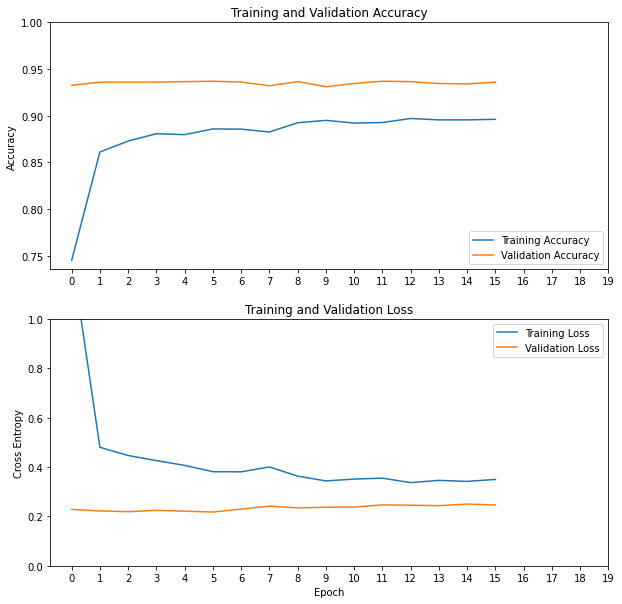

In [18]:
# Plot the training and validation loss

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

### Remarks

Here, we have recieved a model that can classify between 120 classes with an accuracy of about 93.4% on the validation set.